In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('Student_Performance.csv')
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [3]:
data.shape

(10000, 6)

In [4]:
#the describtion of the data to see if there are outliers or not or is there any weird tendances in the data
data.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [6]:
#checking for nulls and duplicates
print(f"Number of nulls: {data.isnull().sum().sum()}")

print(f"Number of duplicates: {data.duplicated().sum()}")

data = data.drop_duplicates()
print(f"Number of duplicates after dropping: {data.duplicated().sum()}")

Number of nulls: 0
Number of duplicates: 127
Number of duplicates after dropping: 0


In [7]:
# Encode categorical column as linear Regression needs the features to be numerical
le = LabelEncoder()
data['Extracurricular Activities'] = le.fit_transform(data['Extracurricular Activities'])

#label encoder gives and index to each unique category it the feature

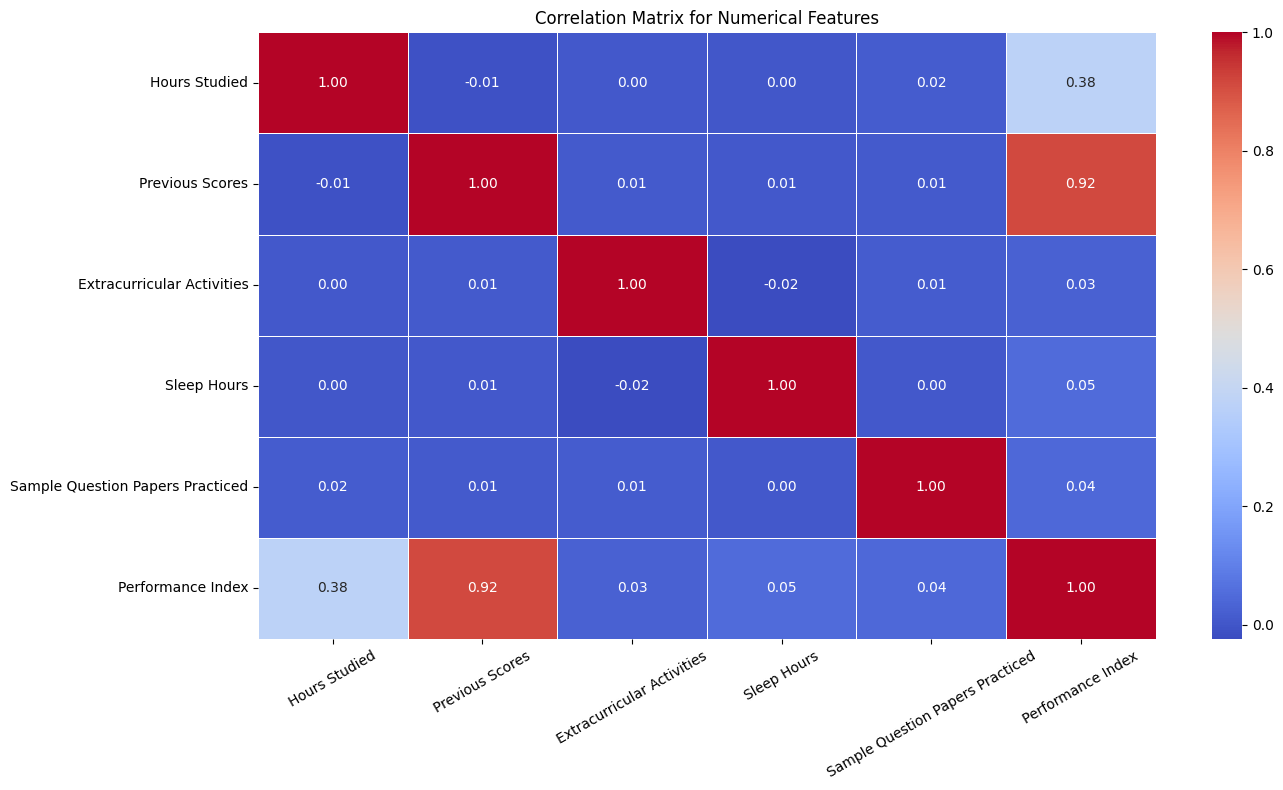

In [8]:
#correlation matrix to see the correlations and dependancies between features
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=30)
plt.title('Correlation Matrix for Numerical Features')
plt.tight_layout()
plt.show()

our predic variable is the Performance index, we can remove features with low corr with our dep. var or high corr between two indep. var to avoid *multicolinearity*

In [9]:
# we can try droping Extracurricular Activities, Sleep Hours and Sample Question Papers Preactices (low corelation between them and the dep.var)
y = data['Performance Index']
X = data.drop('Performance Index', axis=1)

X_Multiple = X[['Hours Studied', 'Previous Scores']]
X1=X['Hours Studied']
X2=X['Previous Scores']


# Standardize the features we do this so the model learns easier and no feature overpowers the other

scaler = StandardScaler()
X_selected_scaled_For_Multiple = pd.DataFrame(scaler.fit_transform(X_Multiple), columns=X_Multiple.columns) #now all features are on the same playing field the model won't favour one over the other


# Split the data
MX_train, MX_test, MY_train, MY_test = train_test_split(X_selected_scaled_For_Multiple, y, test_size=0.1, random_state=42)

print(f"Using features: ['Hours Studied', 'Previous Scores']: {MX_train.shape, MX_test.shape, MY_train.shape, MY_test.shape}")


Using features: ['Hours Studied', 'Previous Scores']: ((8885, 2), (988, 2), (8885,), (988,))


### Model

In [10]:
class MultipleLinearRegression:
    def __init__(self):

        self.B=None
        self.x=None
        self.y=None
        self.n=None
        self.p=None
        self.SSE=None
        self.SSR=None
        self.SST=None
        self.MSE=None
        self.MSR=None
        self.r_squared=None
        self.cof_intervals=None
        self.X_design = None  
        self.df_error = None

        
    def fit(self,x,y):
        self.n = len(x)
        self.X = np.array(x)
        self.y = np.array(y)
        
        self.y_bar = self.y.mean()
        
        self.n, self.f = x.shape
        self.p = self.f + 1
        
        # Create design matrix with intercept
        x = np.c_[np.ones((x.shape[0],1)), x]
        self.X_design = x  # Store design matrix
        self.df_error = self.n - self.p  # Store degrees of freedom
        
        xTx_inverse = np.linalg.inv(x.T @ x)
        xTy = x.T @ y
        
        self.B = xTx_inverse @ xTy   #inverse(Sxx) * Sxy
        
        y_hat = self.predict(x)   # y_hat = B0 + B1x1 +...
        error = y - y_hat
        
        self.SSE = (y.T @ y) - self.B.T @ xTy
        self.MSE = self.SSE / self.df_error
        self.SST = (y.T @ y) - self.n * self.y_bar**2
        self.SSR = self.SST - self.SSE
        
        self.r_squared = self.SSR / self.SST

    
    def predict(self,x):
 
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")
        
        if x.shape[1]==len(self.B)-1:
            x=np.c_[np.ones((x.shape[0],1)),x]
 
        x= np.array(x)
        return x @ self.B


    def plot_3D(self, x, y):
        x = np.array(x)
        y = np.array(y)

        if x.shape[1] != 2:
            raise ValueError("Plotting is only available for models with exactly two independent variables")

        # Inverse transform x to get original feature values
        x_unscaled = scaler.inverse_transform(x)
        x1 = x_unscaled[:, 0]  # Hours Studied
        x2 = x_unscaled[:, 1]  # Previous Scores

        # Create figure with specific size and background color
        fig = plt.figure(figsize=(12, 10), facecolor='white')
        ax = fig.add_subplot(111, projection='3d')

        # Set background color
        ax.set_facecolor('white')

        # Add a grid with custom style - increased density
        ax.grid(True, linestyle='-', alpha=0.6, color='gray')

        # Scatter plot with darker blue color
        scatter = ax.scatter(x2, x1, y, color='#0343df', s=50, label='Actual', alpha=0.8)

        # Create meshgrid for the regression plane with increased resolution
        x2_grid, x1_grid = np.meshgrid(
            np.linspace(x2.min(), x2.max(), 50),
            np.linspace(x1.min(), x1.max(), 50)
        )

        # Create scaled grid for prediction
        x_grid_unscaled = np.c_[x1_grid.ravel(), x2_grid.ravel()]
        x_grid_scaled = scaler.transform(x_grid_unscaled)
        x_grid_scaled = np.c_[np.ones(x_grid_scaled.shape[0]), x_grid_scaled]
        y_grid = (x_grid_scaled @ self.B).reshape(x1_grid.shape)

        # Plot the regression plane with darker colormap
        custom_cmap = plt.cm.get_cmap('viridis').copy()
        custom_cmap.set_under('darkblue')
        
        surf = ax.plot_surface(x2_grid, x1_grid, y_grid, 
                            alpha=0.4,
                            cmap=custom_cmap,
                            vmin=np.min(y_grid) + 0.2 * (np.max(y_grid) - np.min(y_grid)),  # Adjust color range
                            antialiased=True)

        # Style improvements
        ax.set_xlabel('Previous Scores', fontsize=12, labelpad=15)
        ax.set_ylabel('Hours Studied', fontsize=12, labelpad=15)
        ax.set_zlabel('Performance Index', fontsize=12, labelpad=15)
        ax.set_title('3D Multiple Linear Regression', fontsize=14, pad=25)

        # Customize ticks
        ax.tick_params(axis='x', colors='#404040')
        ax.tick_params(axis='y', colors='#404040')
        ax.tick_params(axis='z', colors='#404040')

        # Set specific view angle
        ax.view_init(elev=15, azim=230)

        # Add legend
        ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))

        # Add professional-looking colorbar with darker colors
        colorbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
        colorbar.set_label('Predicted Performance', fontsize=10)
        colorbar.ax.tick_params(colors='#404040')

        # Make grid lines more prominent
        ax.xaxis._axinfo["grid"]['linewidth'] = 0.8
        ax.yaxis._axinfo["grid"]['linewidth'] = 0.8
        ax.zaxis._axinfo["grid"]['linewidth'] = 0.8

        # Remove top and right spines
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        # Make panes slightly transparent
        ax.xaxis.pane.set_alpha(0.1)
        ax.yaxis.pane.set_alpha(0.1)
        ax.zaxis.pane.set_alpha(0.1)

        plt.tight_layout()
        plt.show()
    
    

    def anova_table(self):
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")

        df_regression = self.p - 1  # p includes intercept
        df_error = self.n - self.p
        df_total = self.n - 1

        self.MSR = self.SSR / df_regression
        # MSE = self.SSE / df_error

        F_stat = self.MSR / self.MSE

        anova_data = {
            'Source': ['Regression', 'Error', 'Total'],
            'Sum of Squares': [self.SSR, self.SSE, self.SST],
            'Degrees of Freedom': [df_regression, df_error, df_total],
            'Mean Square': [self.MSR, self.MSE, ""],
            'F-Statistic': [F_stat, "", ""]
        }
        anova_table = pd.DataFrame(anova_data)
        return anova_table



    def overall_f_test(self, alpha=0.05):
        
        if self.B is None:
            raise ValueError('Model not fitted yet.')
        
        
        df_regression = self.p -1
        df_error = self.n - self.p
        
        
        F_stat = self.MSR / self.MSE
        F_critical = scipy.stats.f.ppf(1-alpha, df_regression, df_error)
        
        print('=' * 60)
        print('\t\tHypothesis Testing Results\t\t')
        print('=' * 60)
        print(f'{'Null Hypothsis (H_0):':<25} All coefficients = 0')
        print(f'{'Alternative Hypothsis (H_a):':<25} At least one coefficient ≠ 0')
        print('-' * 60)
        print(f'{'F-Statistic (F_0):':<25}{F_stat:.4f}')
        print(f'{'Critical Value(F_c):':<25}{F_critical:.4f}')
        print('-' * 60)
        
        if F_stat > F_critical:
            print('Reject H_0: the model is statistically significant.')
        else:
            print('Fail to reject H_0: the model is not statistically significant.')
            
        print('=' * 60)
        


    def partial_f_test(self, predictors_to_test, alpha=0.05):

        # Create reduced X by dropping specified predictors (convert 1-based to 0-based indices)
        cols_to_drop = [i - 1 for i in predictors_to_test]
        X_reduced = np.delete(self.X, cols_to_drop, axis=1)
        
        # Fit the reduced model
        reduced_model = MultipleLinearRegression()
        reduced_model.fit(X_reduced, self.y)
        
        # Calculate SSE for both models
        sse_full = self.SSE
        sse_reduced = reduced_model.SSE
        
        # Degrees of freedom
        df_numerator = len(predictors_to_test)
        df_denominator = self.n - self.p
        
        # Compute F-statistic
        numerator = (sse_reduced - sse_full) / df_numerator
        denominator = sse_full / df_denominator
        f_stat = numerator / denominator
        
        # Compute critical F-value
        critical_f = scipy.stats.f.ppf(1 - alpha, df_numerator, df_denominator)
        
        # Format predictor labels (β₁, β₂, etc.)
        betas = [f"β{i}" for i in predictors_to_test]
        beta_str = " = ".join(betas) + " = 0"
        alt_betas = " or ".join([f"{b} ≠ 0" for b in betas])
        
        # Print full conclusion
        print("\n" + "="*60)
        print(f"Partial F-Test for Predictors: {', '.join(betas)}")
        print("-"*60)
        print("Hypotheses:")
        print(f"  H₀: {beta_str}")
        print(f"  H₁: At least one of {', '.join(betas)} is non-zero ({alt_betas})")
        print("\nResults:")
        print(f"  F-Statistic: {f_stat:.4f}")
        print(f"  Critical F-Value (α={alpha}): {critical_f:.4f}")
        print("\nConclusion:")
        if f_stat > critical_f:
            print(f"  Reject H₀ at α={alpha}. The predictor(s) {', '.join(betas)} "
                  "SIGNIFICANTLY contribute to the model.")
        else:
            print(f"  Fail to reject H₀ at α={alpha}. The predictor(s) {', '.join(betas)} "
                  "do NOT significantly contribute to the model.")
        print("="*60 + "\n")    



    def interval_estimation(self, alpha=0.05):
        """
        Calculate confidence intervals for regression coefficients using t-distribution
        since population variance (σ²) is unknown and estimated from data
        
        Parameters:
        -----------
        alpha : float
            Significance level (default 0.05 for 95% confidence)
        
        Returns:
        --------
        DataFrame with confidence intervals for each coefficient
        """
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")
        
        # Calculate standard errors using MSE (estimated variance)
        df = self.df_error
        MSE = self.SSE / df
        var_B = MSE * np.linalg.inv(self.X_design.T @ self.X_design)
        se_B = np.sqrt(np.diag(var_B))
        
        # Get critical value from t-distribution
        t_crit = scipy.stats.t.ppf(1 - alpha/2, df)
        
        # Calculate confidence intervals
        intervals = []
        features = ['Intercept', 'Hours Studied', 'Previous Scores']
        
        for i, (b, se) in enumerate(zip(self.B, se_B)):
            lower = b - t_crit * se
            upper = b + t_crit * se
            intervals.append((lower, upper))
            print(f"{features[i]}: {b:.4f} | CI {100*(1-alpha):.1f}%: ({lower:.4f}, {upper:.4f})")
        
        return pd.DataFrame({
            'Feature': features,
            'Coefficient': self.B,
            'Std Error': se_B,
            f'CI Lower ({(1-alpha)*100}%)': [i[0] for i in intervals],
            f'CI Upper ({(1-alpha)*100}%)': [i[1] for i in intervals]
        })
    

### Fit

In [11]:
model=MultipleLinearRegression()

model.fit(MX_train,MY_train)


print(f"wieghts = {model.B}")
print(f"SSE = {model.SSE}")
print(f"MSE = {model.MSE}")
print(f"SSR = {model.SSR}")
print(f"SST = {model.SSR}")
print(f"r_squared = {model.r_squared}")

wieghts = [55.21678699  7.39240442 17.6516544 ]
SSE = 46261.979585029185
MSE = 5.20850929802175
SSR = 3227015.981472932
SST = 3227015.981472932
r_squared = 0.9858667732666135


we can notice here slightly improved model (R_score & MSE), 
if you tried working just with "Previous Scores" alone you will get a less effictive model due to removing a feature with good correlation with the performance index "Hours Studied" which can be effictive in predicting the dependent variable.

### Prediction

In [12]:

y_pred = model.predict(MX_test)

# Inverse transform the scaled test features to get original values
X1_test_unscaled = scaler.inverse_transform(MX_test)
X1_test_unscaled_df = pd.DataFrame(X1_test_unscaled, columns=['Hours Studied', 'Previous Scores']).round(0).astype(int)

# Create DataFrames for predictions and actual values
y_prediction = pd.DataFrame(y_pred, columns=['y_predicted'])
y1_test_df = pd.DataFrame(MY_test.reset_index(drop=True), columns=['Performance Index'])

# Concatenate the unscaled features, actual values, and predictions
results = pd.concat([X1_test_unscaled_df.reset_index(drop=True),
                     y1_test_df.reset_index(drop=True),
                     y_prediction.reset_index(drop=True)], axis=1)


#to check prediction accuracy we can calculate the MSE for test set, note: should be close to the training MSE
test_mse = np.mean((y_pred - MY_test) ** 2)
print(f"Test MSE: {test_mse:.4f}")
print()
# Display the results
display(results.head(10).style.hide(axis='index'))


Test MSE: 5.5553



Hours Studied,Previous Scores,Performance Index,y_predicted
4,64,47.000000,46.840198
7,90,76.000000,81.896941
6,73,62.000000,61.720770
3,43,23.000000,22.588544
9,76,76.000000,73.343486
8,89,83.000000,83.733438
7,70,60.000000,61.519526
1,76,51.000000,50.500544
4,56,38.000000,38.689232
8,62,58.000000,56.223927


### 3D Plot

d:\Python\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\LAMIA ARABY\AppData\Local\Temp\ipykernel_6760\3000672024.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis').copy()


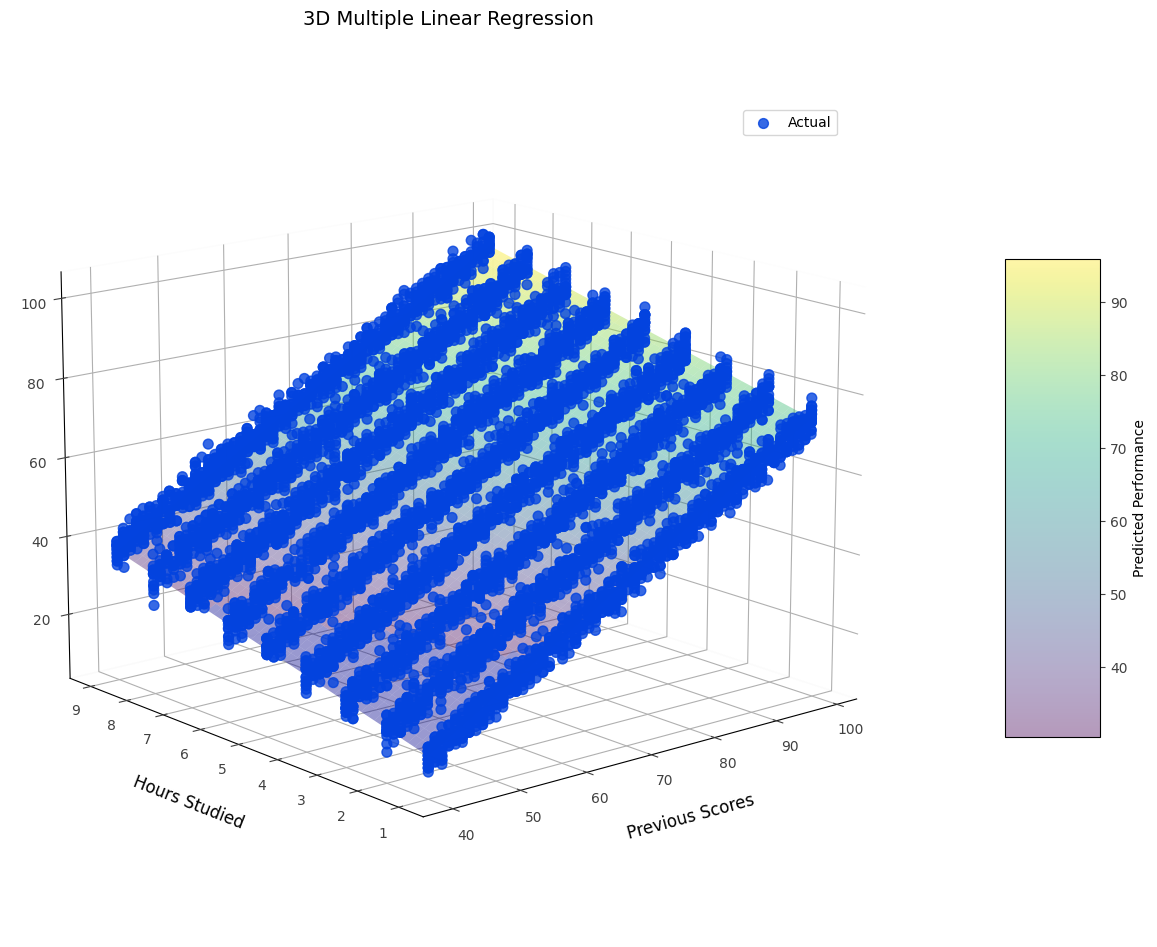

In [13]:
model.plot_3D(MX_train,MY_train)

In [14]:
model.anova_table()

,Source,Sum of Squares,Degrees of Freedom,Mean Square,F-Statistic
0,Regression,3.227016e+06,2,1613507.990736,309783.068132
1,Error,4.626198e+04,8882,5.208509,
2,Total,3.273278e+06,8884,,


In [15]:
model.overall_f_test()

		Hypothesis Testing Results		
Null Hypothsis (H_0):     All coefficients = 0
Alternative Hypothsis (H_a): At least one coefficient ≠ 0
------------------------------------------------------------
F-Statistic (F_0):       309783.0681
Critical Value(F_c):     2.9967
------------------------------------------------------------
Reject H_0: the model is statistically significant.


In [16]:
model.partial_f_test([1])


Partial F-Test for Predictors: β1
------------------------------------------------------------
Hypotheses:
  H₀: β1 = 0
  H₁: At least one of β1 is non-zero (β1 ≠ 0)

Results:
  F-Statistic: 93398.6447
  Critical F-Value (α=0.05): 3.8425

Conclusion:
  Reject H₀ at α=0.05. The predictor(s) β1 SIGNIFICANTLY contribute to the model.



In [17]:
model.partial_f_test([2])


Partial F-Test for Predictors: β2
------------------------------------------------------------
Hypotheses:
  H₀: β2 = 0
  H₁: At least one of β2 is non-zero (β2 ≠ 0)

Results:
  F-Statistic: 530781.5704
  Critical F-Value (α=0.05): 3.8425

Conclusion:
  Reject H₀ at α=0.05. The predictor(s) β2 SIGNIFICANTLY contribute to the model.



In [20]:
model.partial_f_test([1,2])  # Test if both predictors significantly contribute to the model


Partial F-Test for Predictors: β1, β2
------------------------------------------------------------
Hypotheses:
  H₀: β1 = β2 = 0
  H₁: At least one of β1, β2 is non-zero (β1 ≠ 0 or β2 ≠ 0)

Results:
  F-Statistic: 309783.0681
  Critical F-Value (α=0.05): 2.9967

Conclusion:
  Reject H₀ at α=0.05. The predictor(s) β1, β2 SIGNIFICANTLY contribute to the model.



In [19]:
# display confidence intervals
alpha = 0.05
confidence_intervals = model.interval_estimation(alpha)
display(confidence_intervals)

Intercept: 55.2168 | CI 95.0%: (55.1693, 55.2642)
Hours Studied: 7.3924 | CI 95.0%: (7.3450, 7.4398)
Previous Scores: 17.6517 | CI 95.0%: (17.6042, 17.6991)


,Feature,Coefficient,Std Error,CI Lower (95.0%),CI Upper (95.0%)
0,Intercept,55.216787,0.024212,55.169325,55.264249
1,Hours Studied,7.392404,0.024189,7.344989,7.439820
2,Previous Scores,17.651654,0.024229,17.604161,17.699148
